# **Convert detailed management info to machine-readable format**

</br>

</br>

---

# Imports

---

In [1]:
import datetime
from collections import Counter
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from diive.core.io.files import save_parquet, load_parquet
from diive.pkgs.createvar.timesince import TimeSince
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.plotting.timeseries import TimeSeries

</br>

</br>

---

# Read data

---

## Read wind direction data from merged flux data
- Here only needed for wind direction `WD`

In [2]:
FILEPATH = r"../60_FluxProcessingChain/53.1_FluxProcessingChain_after-L3.3_NEE_LE_H.parquet"
fluxdf = load_parquet(filepath=FILEPATH)
winddir = fluxdf['WD'].copy()
winddir

Loaded .parquet file ../60_FluxProcessingChain/53.1_FluxProcessingChain_after-L3.3_NEE_LE_H.parquet (0.688 seconds). Detected time resolution of <30 * Minutes> / 30min 


TIMESTAMP_MIDDLE
2005-01-01 00:15:00        NaN
2005-01-01 00:45:00        NaN
2005-01-01 01:15:00        NaN
2005-01-01 01:45:00        NaN
2005-01-01 02:15:00        NaN
                        ...   
2023-12-31 21:45:00    116.724
2023-12-31 22:15:00    116.197
2023-12-31 22:45:00    142.519
2023-12-31 23:15:00    140.207
2023-12-31 23:45:00    135.988
Freq: 30min, Name: WD, Length: 333072, dtype: float64

## Read management data

In [3]:
file_mgmt = r"../0_data/MANAGEMENT/CH-CHA-Management_2005-2024_20241107.xlsx"
sheet = "CHA_Management"
mgmt_detailed = pd.read_excel(file_mgmt, sheet_name=sheet)
mgmt_detailed = mgmt_detailed.loc[:, ['Parcel', 'Management_Category', 'Management_Subcategory', 'Management_specific', 'Start', 'End', 'Total Fertilizer N (kg/ha)']]
mgmt_detailed 

,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha)
0,A,Fertilization,Organic fertilizer,Manure,2001-01-15,NaT,206.700313
1,A,Plant protection and growth maintenance,Herbe removal,Rumex removal,2001-03-30,NaT,NaN
2,A,Plant protection and growth maintenance,Harrowing,Harrowing (1 cm),2001-04-02,NaT,NaN
3,A,Use,Grazing,Cattle,2001-05-07,2001-05-15,NaN
4,A,Plant protection and growth maintenance,Rolling,NaN,2001-06-07,NaT,NaN
...,...,...,...,...,...,...,...
573,B,Fertilization,Organic fertilizer,Slurry,2024-06-27,2024-06-27,NaN
574,B,Use,Mowing,NaN,2024-07-17,2024-07-17,NaN
575,B,Fertilization,Organic fertilizer,Slurry,2024-08-07,2024-08-07,NaN
576,B,Use,Mowing,NaN,2024-08-22,2024-08-22,NaN


</br>

</br>

---

# **MANAGEMENT EVENTS DAILY** (daily scale)

---

## Handle missing management info

In [4]:
# Some dates have time info, removed in this step, keep only date
mgmt_detailed['Start'] = pd.to_datetime(mgmt_detailed['Start']).dt.date
mgmt_detailed['End'] = pd.to_datetime(mgmt_detailed['End']).dt.date

In [5]:
# Fill end dates, if missing then end is the same as start
mgmt_detailed['End'] = mgmt_detailed['End'].fillna(mgmt_detailed['Start'])

mgmt_detailed['Parcel'] = mgmt_detailed['Parcel'].fillna('-9999')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].fillna('-9999')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].fillna('-9999')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].fillna('-9999')
mgmt_detailed['Total Fertilizer N (kg/ha)'] = mgmt_detailed['Total Fertilizer N (kg/ha)'].fillna(0)
mgmt_detailed

,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha)
0,A,Fertilization,Organic fertilizer,Manure,2001-01-15,2001-01-15,206.700313
1,A,Plant protection and growth maintenance,Herbe removal,Rumex removal,2001-03-30,2001-03-30,0.000000
2,A,Plant protection and growth maintenance,Harrowing,Harrowing (1 cm),2001-04-02,2001-04-02,0.000000
3,A,Use,Grazing,Cattle,2001-05-07,2001-05-15,0.000000
4,A,Plant protection and growth maintenance,Rolling,-9999,2001-06-07,2001-06-07,0.000000
...,...,...,...,...,...,...,...
573,B,Fertilization,Organic fertilizer,Slurry,2024-06-27,2024-06-27,0.000000
574,B,Use,Mowing,-9999,2024-07-17,2024-07-17,0.000000
575,B,Fertilization,Organic fertilizer,Slurry,2024-08-07,2024-08-07,0.000000
576,B,Use,Mowing,-9999,2024-08-22,2024-08-22,0.000000


In [6]:
# mgmt_detailed.count()

In [7]:
# ## Make full timestamp for start and end dates
# - The full timestamp for start and end dates takes into account that the flux records are stored with a timestamp that shows the END of the averaging interval
# - This means that a record with timestamp `2021-06-05 00:00` contains data between `2021-06-04 23:30` (exclusive) and `2021-06-05 00:00` (inclusive)
# - To correctly assign a management to a specific day, one second needs to be added to the start date (because the time 00:00 still has data from the *previous* day)
# - For the end data to cover the full day, 24 hours need to be added and in addition one second, to include the 00:00 time of the next day
# mgmt_detailed['Start'] = pd.to_datetime(mgmt_detailed['Start']).add(datetime.timedelta(seconds=1))
# mgmt_detailed['End'] = pd.to_datetime(mgmt_detailed['End']).add(datetime.timedelta(hours=24, seconds=1))
# mgmt_detailed

</br>

## Create `MGMT_SPECIFIC` variables

In [8]:
# Add PREFIX column, use MGMT when building variable names later
mgmt_detailed['PREFIX'] = 'MGMT'

# Rename parcels
mgmt_detailed['Parcel'] = mgmt_detailed['Parcel'].str.replace('A', 'PARCEL-A')
mgmt_detailed['Parcel'] = mgmt_detailed['Parcel'].str.replace('B', 'PARCEL-B')

### Rename Management_Category

In [9]:
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Fertilization', 'FERT')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Plant protection and growth maintenance', 'PPGM')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Use', 'USE')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Sowing', 'SOWING')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Soil cultivation', 'SOILCULTIVATION')

### Rename Management_Subcategory

In [10]:
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Organic fertilizer', 'ORG')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Mineral fertilizer', 'MIN')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Herbe removal', 'HERBREMOVAL')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Harrowing', 'HARROWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Grazing', 'GRAZING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Rolling', 'ROLLING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Oversowing', 'OVERSOWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Mowing', 'MOWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Herbicide', 'HERBICIDE')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Ploughing', 'PLOUGHING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Resowing', 'RESOWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Pesticide', 'PESTICIDE')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Tillage', 'TILLAGE')

### Rename Management_specific

In [11]:
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Manure', 'MAN')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Slurry', 'SLU')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Calcium ammonium nitrate', 'CAN')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Molluscicide (applied on the whole field)', 'MOLLUSCICIDE')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Harmony tabs (applied on single plants against Rumex obtusifolius)', 'HARMONYTABS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Ally Tabs (applied on single plants against Rumex spp.)', 'ALLYTABS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Ally Tabs (applied against Rumex spp. and Senecio spp.)', 'ALLYTABS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Hay', 'HAY')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Sheep', 'SHEEP')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Cattle', 'CATTLE')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Aftergrass', 'AFTERGRASS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Asulox (applied on the whole field against Rumex obtusifolius)', 'ASULOX')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Rumex removal', 'RUMEX')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Harrowing (1 cm)', '1CM')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Harrowing (7 cm)', '7CM')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Roundup PowerMax', 'ROUNDUP')

mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 440 Extra', 'OH440EXTRA')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('?', '-9999')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 440 RenoTurbo', 'OH440RENOTURBO')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 440 Reno', 'OH440RENO')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 240 Reno', 'OH240RENO')

mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Asulam (applied on the whole field against Rumex obtusifolius)', 'ASULAM')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Grass silage', 'GRASSSILAGE')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('UFA 420', 'UFA-420')

s = "HEBE FIONA MERULA. Sorte HEBE: Trifolium repens (small leaves). Sorte FIONA: Trifolium repens (big leaves). Sorte MERULA: Trifolium pratense. Total 20 kg/ha. Mixture: 1/4 HEBE  1/2 FIONA 1/4 MERULA"
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace(s, 'HEBE-FIONA-MERULA')

s = "HEBE FIONA MERULA. Sorte HEBE: Trifolium repens (small leaves). Sorte FIONA: Trifolium repens (big leaves). Sorte MARULA: Trifolium pratense. Total 20 kg/ha. Mixture: 27% HEBE  36% FIONA 36% MERULA (15 kg + 20 kg + 20 kg)"
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace(s, 'HEBE-FIONA-MERULA')

s = "Type OH (HEBE FIONA TEDI). Trifolium pratense 4n Sorte TEDI - Trifolium repens Sorte HEBE - Trifolium repens Sorte FIONA. Total 200 g/a of each 1/3"
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace(s, 'HEBE-FIONA-TEDI')

mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Hobelsaat (tillage until 3-4 cm)', '3-4CM')

### Assemble `MGMT_SPECIFIC`variable name

In [12]:
def create_varname(row): 
    return "_".join([
        row['PREFIX'],        
        row['Management_Category'], 
        row['Management_Subcategory'],
        str(row['Management_specific']),
        # row['Parcel']
    ])

mgmt_detailed['MGMT_SPECIFIC'] = mgmt_detailed.apply(create_varname, axis=1)
mgmt_detailed['MGMT_SPECIFIC'] = mgmt_detailed['MGMT_SPECIFIC'].str.replace('_-9999', '')
mgmt_types = mgmt_detailed['MGMT_SPECIFIC'].unique()

In [13]:
# List of unique specific managements
print("Unique specific managements:")
[print(f"{ix + 1}: {v}") for ix, v in enumerate(mgmt_types)];

Unique specific managements:
1: MGMT_FERT_ORG_MAN
2: MGMT_PPGM_HERBREMOVAL_RUMEX
3: MGMT_PPGM_HARROWING_1CM
4: MGMT_USE_GRAZING_CATTLE
5: MGMT_PPGM_ROLLING
6: MGMT_PPGM_HARROWING_7CM
7: MGMT_SOWING_OVERSOWING_OH440RENO
8: MGMT_USE_MOWING_GRASSSILAGE
9: MGMT_FERT_MIN_CAN
10: MGMT_FERT_ORG_SLU
11: MGMT_USE_GRAZING_SHEEP
12: MGMT_SOWING_OVERSOWING_OH440EXTRA
13: MGMT_USE_MOWING_AFTERGRASS
14: MGMT_PPGM_HERBICIDE_ASULOX
15: MGMT_SOILCULTIVATION_ROLLING
16: MGMT_USE_MOWING_HAY
17: MGMT_SOWING_OVERSOWING_OH440RENOTURBO
18: MGMT_SOWING_OVERSOWING_OH240RENO
19: MGMT_PPGM_HERBICIDE_ALLYTABS
20: MGMT_SOILCULTIVATION_PLOUGHING
21: MGMT_SOILCULTIVATION_HARROWING_7CM
22: MGMT_SOWING_RESOWING_OH440EXTRA
23: MGMT_PPGM_PESTICIDE_MOLLUSCICIDE
24: MGMT_PPGM_HERBICIDE_HARMONYTABS
25: MGMT_PPGM_HERBICIDE_ASULAM
26: MGMT_SOWING_OVERSOWING_HEBE-FIONA-TEDI
27: MGMT_SOILCULTIVATION_HARROWING_1CM
28: MGMT_USE_MOWING
29: MGMT_SOWING_OVERSOWING_HEBE-FIONA-MERULA
30: MGMT_PPGM_HERBICIDE_ROUNDUP
31: MGMT_SOILCULTI

In [14]:
mgmt_detailed

,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC
0,PARCEL-A,FERT,ORG,MAN,2001-01-15,2001-01-15,206.700313,MGMT,MGMT_FERT_ORG_MAN
1,PARCEL-A,PPGM,HERBREMOVAL,RUMEX,2001-03-30,2001-03-30,0.000000,MGMT,MGMT_PPGM_HERBREMOVAL_RUMEX
2,PARCEL-A,PPGM,HARROWING,1CM,2001-04-02,2001-04-02,0.000000,MGMT,MGMT_PPGM_HARROWING_1CM
3,PARCEL-A,USE,GRAZING,CATTLE,2001-05-07,2001-05-15,0.000000,MGMT,MGMT_USE_GRAZING_CATTLE
4,PARCEL-A,PPGM,ROLLING,-9999,2001-06-07,2001-06-07,0.000000,MGMT,MGMT_PPGM_ROLLING
...,...,...,...,...,...,...,...,...,...
573,PARCEL-B,FERT,ORG,SLU,2024-06-27,2024-06-27,0.000000,MGMT,MGMT_FERT_ORG_SLU
574,PARCEL-B,USE,MOWING,-9999,2024-07-17,2024-07-17,0.000000,MGMT,MGMT_USE_MOWING
575,PARCEL-B,FERT,ORG,SLU,2024-08-07,2024-08-07,0.000000,MGMT,MGMT_FERT_ORG_SLU
576,PARCEL-B,USE,MOWING,-9999,2024-08-22,2024-08-22,0.000000,MGMT,MGMT_USE_MOWING


### Counts of `MGMT_SPECIFIC`

In [15]:
counts = Counter(mgmt_detailed['MGMT_SPECIFIC'])
counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
rename_dict = {'index': 'MGMT_SPECIFIC', 0: 'COUNTS'}
counts_df = counts_df.rename(columns=rename_dict, inplace=False)
counts_df = counts_df.sort_values(by='COUNTS', ascending=False)
counts_df.to_csv("21.1_mgmt_specific_counts.csv", index=False)
counts_df

,MGMT_SPECIFIC,COUNTS
9,MGMT_FERT_ORG_SLU,190
7,MGMT_USE_MOWING_GRASSSILAGE,134
10,MGMT_USE_GRAZING_SHEEP,60
27,MGMT_USE_MOWING,41
12,MGMT_USE_MOWING_AFTERGRASS,36
15,MGMT_USE_MOWING_HAY,17
6,MGMT_SOWING_OVERSOWING_OH440RENO,12
3,MGMT_USE_GRAZING_CATTLE,8
2,MGMT_PPGM_HARROWING_1CM,8
0,MGMT_FERT_ORG_MAN,7


## Simplify and group `MGMT` variables
Group variables into 7 general categories:
- MGMT_MOWING, MGMT_GRAZING, MGMT_SOWING, MGMT_SOILCULTIVATION, MGMT_PESTICIDE_HERBICIDE, MGMT_FERT_ORG, MGMT_FERT_MIN

In [16]:
mgmt_detailed['MGMT_GENERAL'] = ''
mgmt_detailed['MGMT_PARCEL'] = ''

def rename(startswith, replacewith):
    
    locs = mgmt_detailed['MGMT_SPECIFIC'].str.startswith(startswith)

    mgmt_detailed.loc[locs, 'MGMT_GENERAL'] = replacewith
    mgmt_detailed.loc[locs, 'MGMT_PARCEL'] = replacewith + "_" + mgmt_detailed.loc[locs, 'Parcel']
    display(mgmt_detailed[locs].head(1))   
    print(f"Records: {len(mgmt_detailed[locs])}")

rename(startswith="MGMT_USE_MOWING", replacewith="MGMT_MOWING")

rename(startswith="MGMT_USE_GRAZING", replacewith="MGMT_GRAZING")

rename(startswith="MGMT_SOWING", replacewith="MGMT_SOWING")

rename(startswith="MGMT_SOILCULTIVATION", replacewith="MGMT_SOILCULTIVATION")
rename(startswith="MGMT_PPGM_HARROWING", replacewith="MGMT_SOILCULTIVATION")
rename(startswith="MGMT_PPGM_ROLLING", replacewith="MGMT_SOILCULTIVATION")

rename(startswith="MGMT_PPGM_PESTICIDE", replacewith="MGMT_PESTICIDE_HERBICIDE")
rename(startswith="MGMT_PPGM_HERBREMOVAL", replacewith="MGMT_PESTICIDE_HERBICIDE")
rename(startswith="MGMT_PPGM_HERBICIDE", replacewith="MGMT_PESTICIDE_HERBICIDE")

rename(startswith="MGMT_FERT_ORG", replacewith="MGMT_FERT_ORG")
rename(startswith="MGMT_FERT_MIN", replacewith="MGMT_FERT_MIN")

,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
7,PARCEL-A,USE,MOWING,GRASSSILAGE,2001-07-25,2001-07-25,0.0,MGMT,MGMT_USE_MOWING_GRASSSILAGE,MGMT_MOWING,MGMT_MOWING_PARCEL-A


Records: 228


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
3,PARCEL-A,USE,GRAZING,CATTLE,2001-05-07,2001-05-15,0.0,MGMT,MGMT_USE_GRAZING_CATTLE,MGMT_GRAZING,MGMT_GRAZING_PARCEL-A


Records: 68


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
6,PARCEL-A,SOWING,OVERSOWING,OH440RENO,2001-06-07,2001-06-07,0.0,MGMT,MGMT_SOWING_OVERSOWING_OH440RENO,MGMT_SOWING,MGMT_SOWING_PARCEL-A


Records: 27


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
139,PARCEL-B,SOILCULTIVATION,ROLLING,-9999,2006-03-27,2006-03-27,0.0,MGMT,MGMT_SOILCULTIVATION_ROLLING,MGMT_SOILCULTIVATION,MGMT_SOILCULTIVATION_PARCEL-B


Records: 16


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
2,PARCEL-A,PPGM,HARROWING,1CM,2001-04-02,2001-04-02,0.0,MGMT,MGMT_PPGM_HARROWING_1CM,MGMT_SOILCULTIVATION,MGMT_SOILCULTIVATION_PARCEL-A


Records: 9


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
4,PARCEL-A,PPGM,ROLLING,-9999,2001-06-07,2001-06-07,0.0,MGMT,MGMT_PPGM_ROLLING,MGMT_SOILCULTIVATION,MGMT_SOILCULTIVATION_PARCEL-A


Records: 3


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
306,PARCEL-A,PPGM,PESTICIDE,MOLLUSCICIDE,2012-06-19,2012-06-19,0.0,MGMT,MGMT_PPGM_PESTICIDE_MOLLUSCICIDE,MGMT_PESTICIDE_HERBICIDE,MGMT_PESTICIDE_HERBICIDE_PARCEL-A


Records: 2


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
1,PARCEL-A,PPGM,HERBREMOVAL,RUMEX,2001-03-30,2001-03-30,0.0,MGMT,MGMT_PPGM_HERBREMOVAL_RUMEX,MGMT_PESTICIDE_HERBICIDE,MGMT_PESTICIDE_HERBICIDE_PARCEL-A


Records: 3


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
70,PARCEL-B,PPGM,HERBICIDE,ASULOX,2003-09-22,2003-09-22,0.0,MGMT,MGMT_PPGM_HERBICIDE_ASULOX,MGMT_PESTICIDE_HERBICIDE,MGMT_PESTICIDE_HERBICIDE_PARCEL-B


Records: 18


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
0,PARCEL-A,FERT,ORG,MAN,2001-01-15,2001-01-15,206.700313,MGMT,MGMT_FERT_ORG_MAN,MGMT_FERT_ORG,MGMT_FERT_ORG_PARCEL-A


Records: 197


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
8,PARCEL-A,FERT,MIN,CAN,2001-08-06,2001-08-06,17.55,MGMT,MGMT_FERT_MIN_CAN,MGMT_FERT_MIN,MGMT_FERT_MIN_PARCEL-A


Records: 7


In [17]:
mgmt_detailed

,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
0,PARCEL-A,FERT,ORG,MAN,2001-01-15,2001-01-15,206.700313,MGMT,MGMT_FERT_ORG_MAN,MGMT_FERT_ORG,MGMT_FERT_ORG_PARCEL-A
1,PARCEL-A,PPGM,HERBREMOVAL,RUMEX,2001-03-30,2001-03-30,0.000000,MGMT,MGMT_PPGM_HERBREMOVAL_RUMEX,MGMT_PESTICIDE_HERBICIDE,MGMT_PESTICIDE_HERBICIDE_PARCEL-A
2,PARCEL-A,PPGM,HARROWING,1CM,2001-04-02,2001-04-02,0.000000,MGMT,MGMT_PPGM_HARROWING_1CM,MGMT_SOILCULTIVATION,MGMT_SOILCULTIVATION_PARCEL-A
3,PARCEL-A,USE,GRAZING,CATTLE,2001-05-07,2001-05-15,0.000000,MGMT,MGMT_USE_GRAZING_CATTLE,MGMT_GRAZING,MGMT_GRAZING_PARCEL-A
4,PARCEL-A,PPGM,ROLLING,-9999,2001-06-07,2001-06-07,0.000000,MGMT,MGMT_PPGM_ROLLING,MGMT_SOILCULTIVATION,MGMT_SOILCULTIVATION_PARCEL-A
...,...,...,...,...,...,...,...,...,...,...,...
573,PARCEL-B,FERT,ORG,SLU,2024-06-27,2024-06-27,0.000000,MGMT,MGMT_FERT_ORG_SLU,MGMT_FERT_ORG,MGMT_FERT_ORG_PARCEL-B
574,PARCEL-B,USE,MOWING,-9999,2024-07-17,2024-07-17,0.000000,MGMT,MGMT_USE_MOWING,MGMT_MOWING,MGMT_MOWING_PARCEL-B
575,PARCEL-B,FERT,ORG,SLU,2024-08-07,2024-08-07,0.000000,MGMT,MGMT_FERT_ORG_SLU,MGMT_FERT_ORG,MGMT_FERT_ORG_PARCEL-B
576,PARCEL-B,USE,MOWING,-9999,2024-08-22,2024-08-22,0.000000,MGMT,MGMT_USE_MOWING,MGMT_MOWING,MGMT_MOWING_PARCEL-B


In [18]:
mgmt_detailed.to_csv("21.3_mgmt_detailed.csv")

In [19]:
print("Check for missing management info:")
mgmt_detailed.isnull().sum()

Check for missing management info:


Parcel                        0
Management_Category           0
Management_Subcategory        0
Management_specific           0
Start                         0
End                           0
Total Fertilizer N (kg/ha)    0
PREFIX                        0
MGMT_SPECIFIC                 0
MGMT_GENERAL                  0
MGMT_PARCEL                   0
dtype: int64

### Count `MGMT_PARCEL` events

In [20]:
counts = Counter(mgmt_detailed['MGMT_PARCEL'])
counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
rename_dict = {'index': 'MGMT_PARCEL', 0: 'COUNTS'}
counts_df = counts_df.rename(columns=rename_dict, inplace=False)
counts_df = counts_df.sort_values(by='COUNTS', ascending=False)
counts_df.to_csv("21.2_mgmt_parcel_counts.csv", index=False)
counts_df

,MGMT_PARCEL,COUNTS
9,MGMT_MOWING_PARCEL-B,118
0,MGMT_FERT_ORG_PARCEL-A,112
5,MGMT_MOWING_PARCEL-A,110
7,MGMT_FERT_ORG_PARCEL-B,85
11,MGMT_GRAZING_PARCEL-B,35
3,MGMT_GRAZING_PARCEL-A,33
12,MGMT_SOWING_PARCEL-B,21
8,MGMT_SOILCULTIVATION_PARCEL-B,17
10,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,12
1,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,11


## Collect management info in daily dataframe

### Create daily timestamp, starting with year of first management event in 2001

In [21]:
timestamp_daily = pd.date_range("2001-01-01", fluxdf.index[-1].date(), freq='d')
timestamp_daily

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04', '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08', '2001-01-09', '2001-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30', '2023-12-31'], dtype='datetime64[ns]', length=8400, freq='D')

In [22]:
# ## Create full timestamp, starting with year of first management event in 2001
# timestamp_full = pd.date_range("2001-01-01 00:15:00", fluxdf.index[-1], freq='30min')
# timestamp_full

### Create empty dataframe

In [23]:
cols = counts_df['MGMT_PARCEL'].tolist()
mgmt_daily = pd.DataFrame(index=timestamp_daily, columns=cols)
mgmt_daily.index

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04', '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08', '2001-01-09', '2001-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30', '2023-12-31'], dtype='datetime64[ns]', length=8400, freq='D')

### Insert management info into management dataframe with daily timestamp

In [24]:
for ix, event in mgmt_detailed.iterrows():
    varname = event['MGMT_PARCEL']
    start = event['Start']
    end = event['End']
    print(f"from {start} to {end}: {varname}")
    locs = (mgmt_daily.index.date >= start) & (mgmt_daily.index.date <= end)    
    mgmt_daily.loc[locs, varname] = 1    

mgmt_daily = mgmt_daily.fillna(0)

from 2001-01-15 to 2001-01-15: MGMT_FERT_ORG_PARCEL-A
from 2001-03-30 to 2001-03-30: MGMT_PESTICIDE_HERBICIDE_PARCEL-A
from 2001-04-02 to 2001-04-02: MGMT_SOILCULTIVATION_PARCEL-A
from 2001-05-07 to 2001-05-15: MGMT_GRAZING_PARCEL-A
from 2001-06-07 to 2001-06-07: MGMT_SOILCULTIVATION_PARCEL-A
from 2001-06-07 to 2001-06-07: MGMT_SOILCULTIVATION_PARCEL-A
from 2001-06-07 to 2001-06-07: MGMT_SOWING_PARCEL-A
from 2001-07-25 to 2001-07-25: MGMT_MOWING_PARCEL-A
from 2001-08-06 to 2001-08-06: MGMT_FERT_MIN_PARCEL-A
from 2001-08-21 to 2001-08-23: MGMT_MOWING_PARCEL-A
from 2001-09-12 to 2001-09-12: MGMT_PESTICIDE_HERBICIDE_PARCEL-A
from 2001-10-15 to 2001-10-16: MGMT_MOWING_PARCEL-A
from 2001-01-16 to 2001-01-16: MGMT_FERT_ORG_PARCEL-B
from 2001-03-30 to 2001-03-30: MGMT_FERT_ORG_PARCEL-B
from 2001-04-20 to 2001-04-20: MGMT_SOILCULTIVATION_PARCEL-B
from 2001-05-09 to 2001-05-10: MGMT_MOWING_PARCEL-B
from 2001-05-11 to 2001-05-11: MGMT_FERT_ORG_PARCEL-B
from 2001-05-22 to 2001-05-22: MGMT_PESTICI

C:\Users\nopan\AppData\Local\Temp\ipykernel_21148\573936329.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mgmt_daily = mgmt_daily.fillna(0)


In [25]:
# mgmt_daily.loc['2002-05-20':'2002-05-23']

In [26]:
mgmt_daily.describe()

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B
count,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.00000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000,8400.000000
mean,0.020833,0.013333,0.019286,0.010119,0.046548,0.050000,0.00250,0.001548,0.001310,0.001190,0.000952,0.000714,0.000595,0.000238
std,0.142835,0.114704,0.137536,0.100089,0.210680,0.217958,0.04994,0.039312,0.036166,0.034485,0.030848,0.026718,0.024392,0.015429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
mgmt_daily.columns

Index(['MGMT_MOWING_PARCEL-B', 'MGMT_FERT_ORG_PARCEL-A', 'MGMT_MOWING_PARCEL-A', 'MGMT_FERT_ORG_PARCEL-B', 'MGMT_GRAZING_PARCEL-B', 'MGMT_GRAZING_PARCEL-A', 'MGMT_SOWING_PARCEL-B', 'MGMT_SOILCULTIVATION_PARCEL-B', 'MGMT_PESTICIDE_HERBICIDE_PARCEL-B', 'MGMT_PESTICIDE_HERBICIDE_PARCEL-A', 'MGMT_SOILCULTIVATION_PARCEL-A', 'MGMT_SOWING_PARCEL-A', 'MGMT_FERT_MIN_PARCEL-A', 'MGMT_FERT_MIN_PARCEL-B'], dtype='object')

### Plots

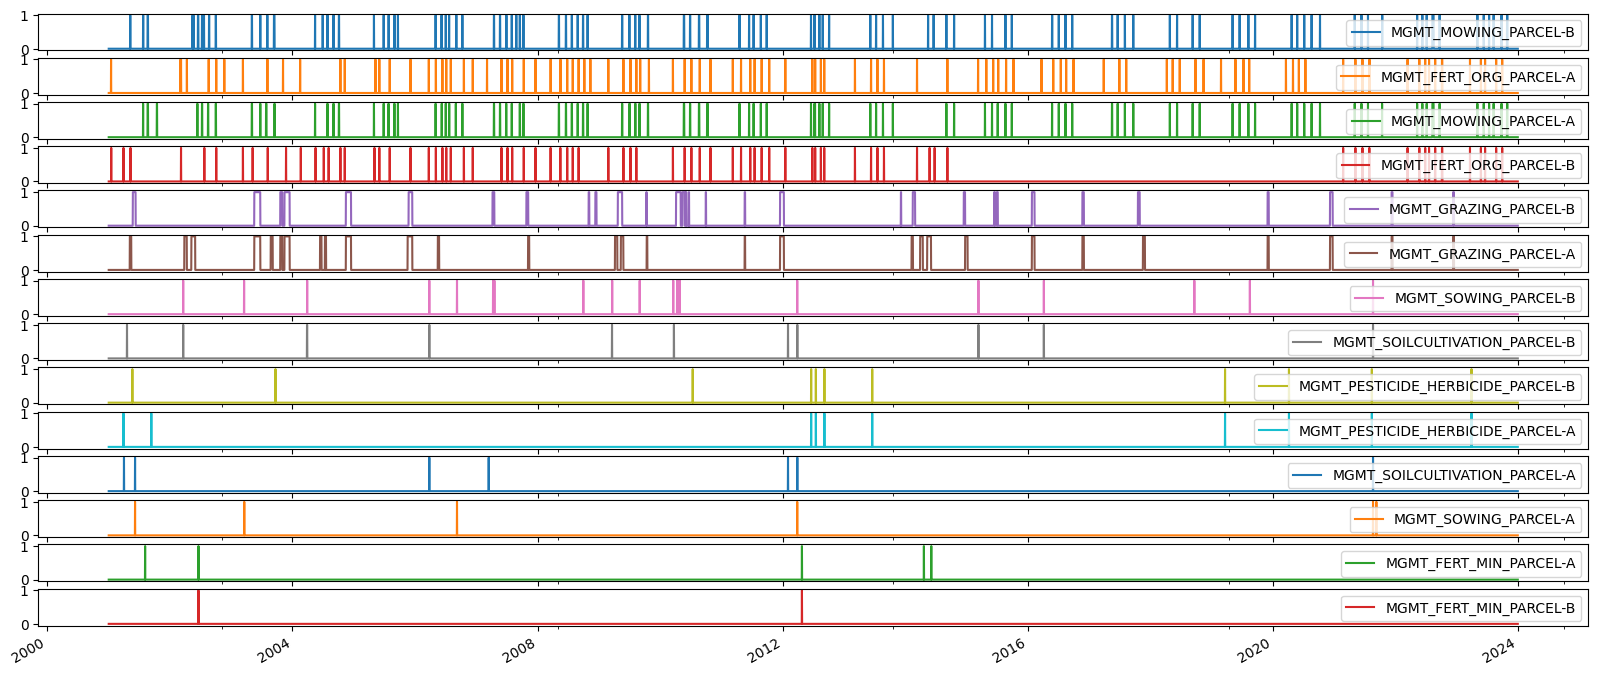

In [28]:
mgmt_daily.plot(x_compat=True, subplots=True, figsize=(20, 9));

## Calculate `TIMESINCE` management event

In [29]:
timesincedf = pd.DataFrame()

for v in mgmt_daily.columns:
    series = mgmt_daily[v].squeeze()    
    ts = TimeSince(series, lower_lim=1, include_lim=True)
    ts.calc()
    # ts_full_results = ts.get_full_results()
    timesince = ts.get_timesince()
    timesincedf[timesince.name] = timesince

In [30]:
timesincedf

,TIMESINCE_MGMT_MOWING_PARCEL-B,TIMESINCE_MGMT_FERT_ORG_PARCEL-A,TIMESINCE_MGMT_MOWING_PARCEL-A,TIMESINCE_MGMT_FERT_ORG_PARCEL-B,TIMESINCE_MGMT_GRAZING_PARCEL-B,TIMESINCE_MGMT_GRAZING_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-B,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-B
2001-01-01,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2001-01-02,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2001-01-03,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2001-01-04,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2001-01-05,5,5,5,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,58,89,58,89,377,377,859,859,272,272,859,839,3492,4263
2023-12-28,59,90,59,90,378,378,860,860,273,273,860,840,3493,4264
2023-12-29,60,91,60,91,379,379,861,861,274,274,861,841,3494,4265
2023-12-30,61,92,61,92,380,380,862,862,275,275,862,842,3495,4266


### Plots

C:\Users\nopan\miniconda3\envs\cha_fp2024\Lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
C:\Users\nopan\miniconda3\envs\cha_fp2024\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


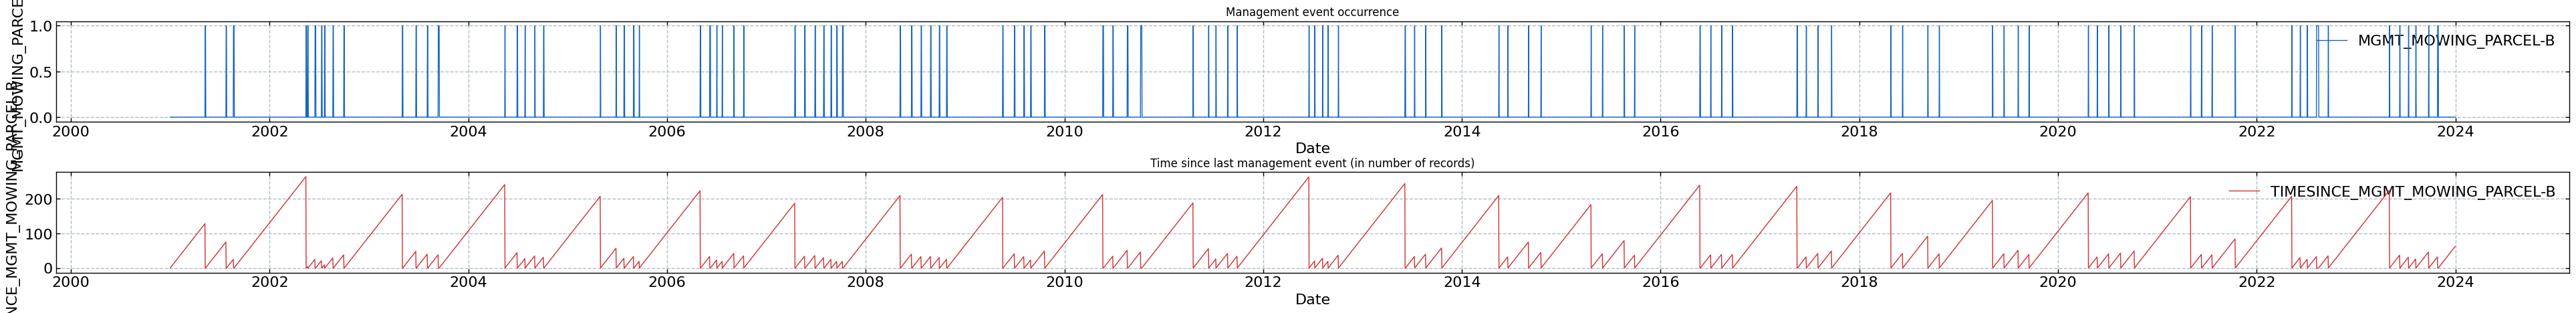

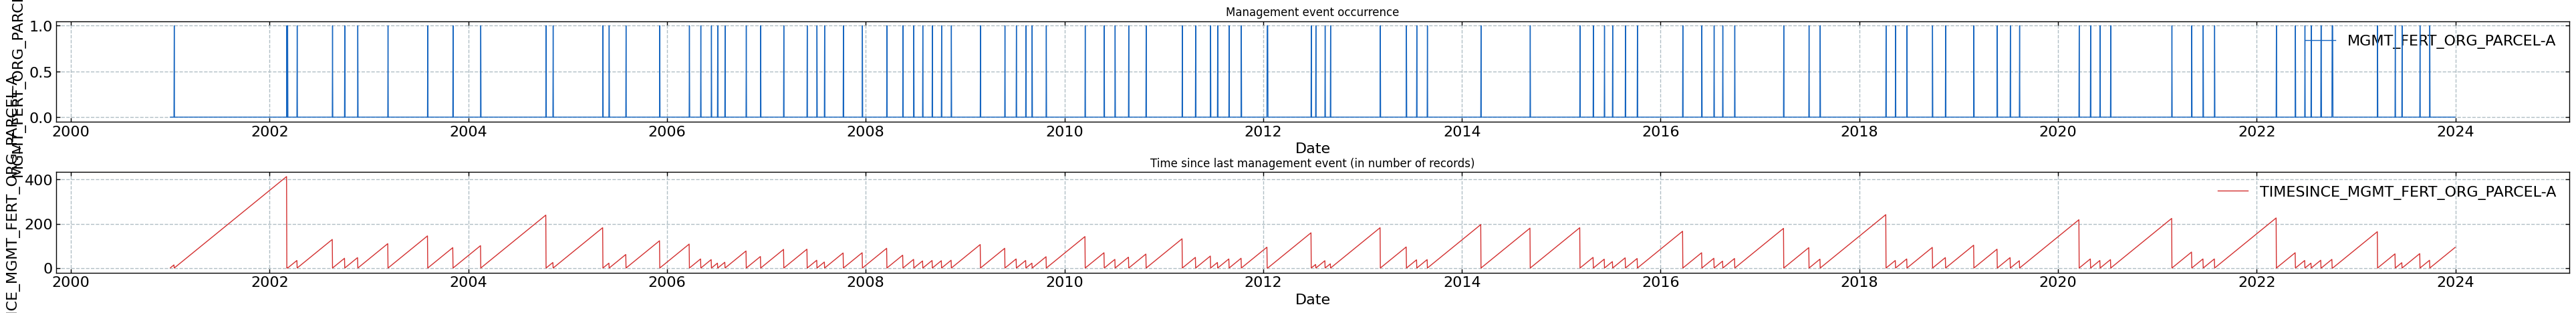

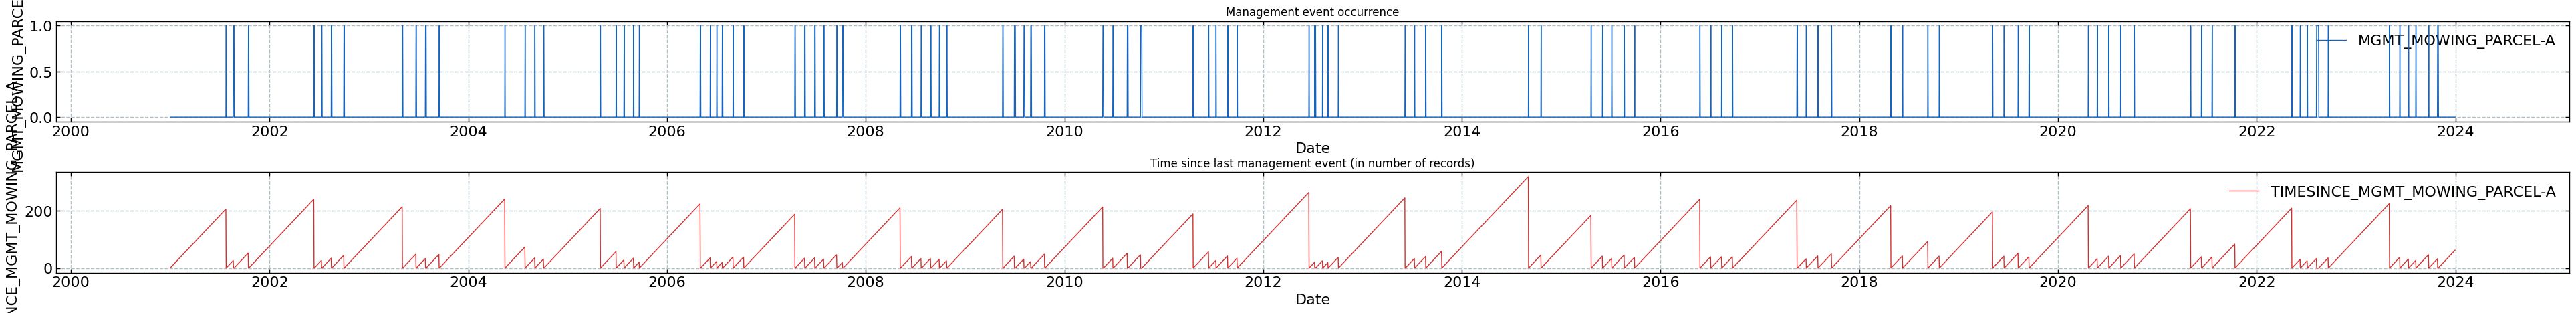

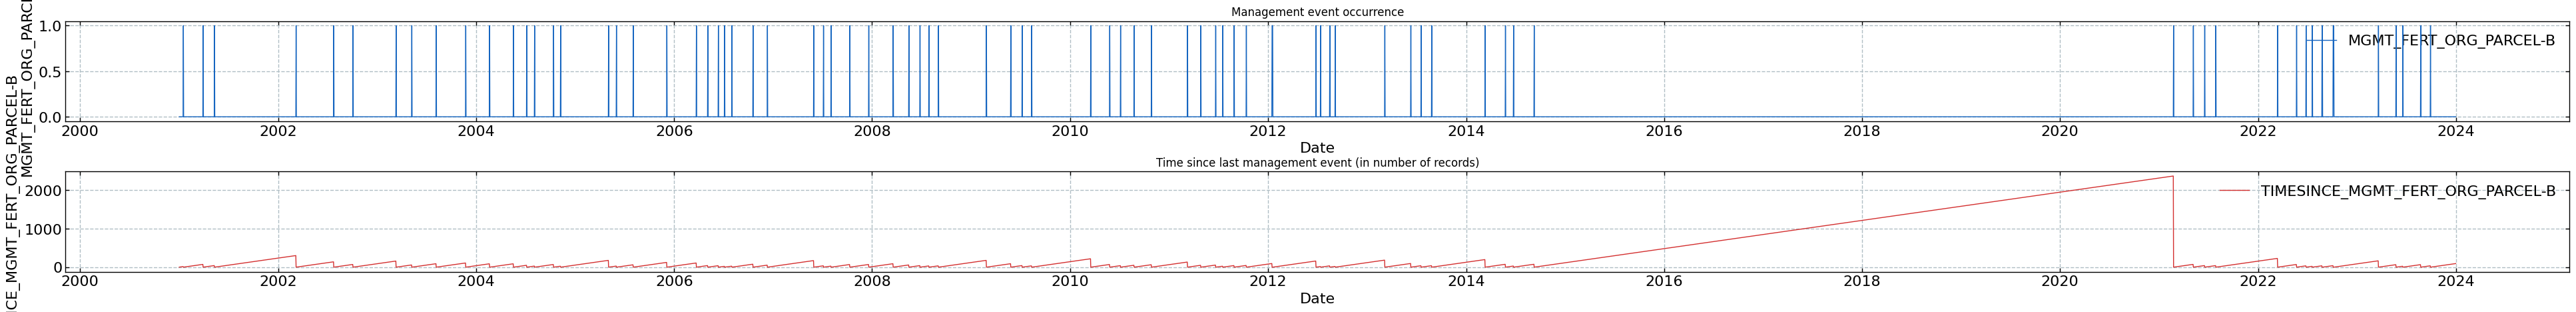

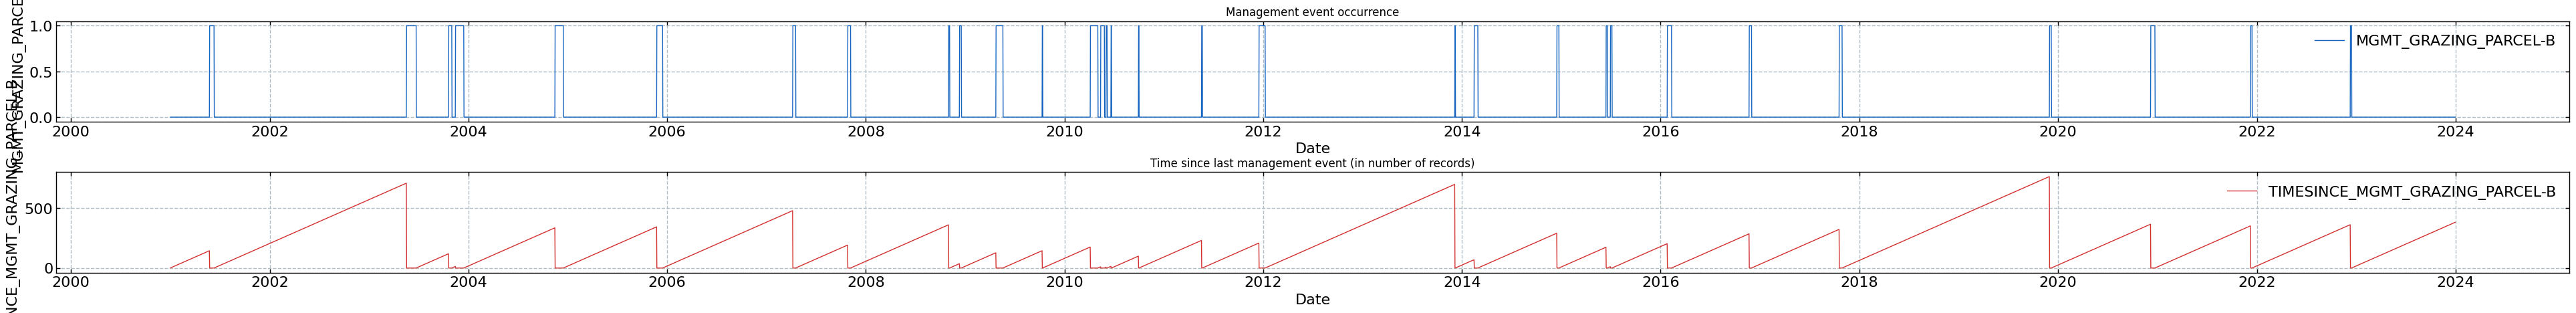

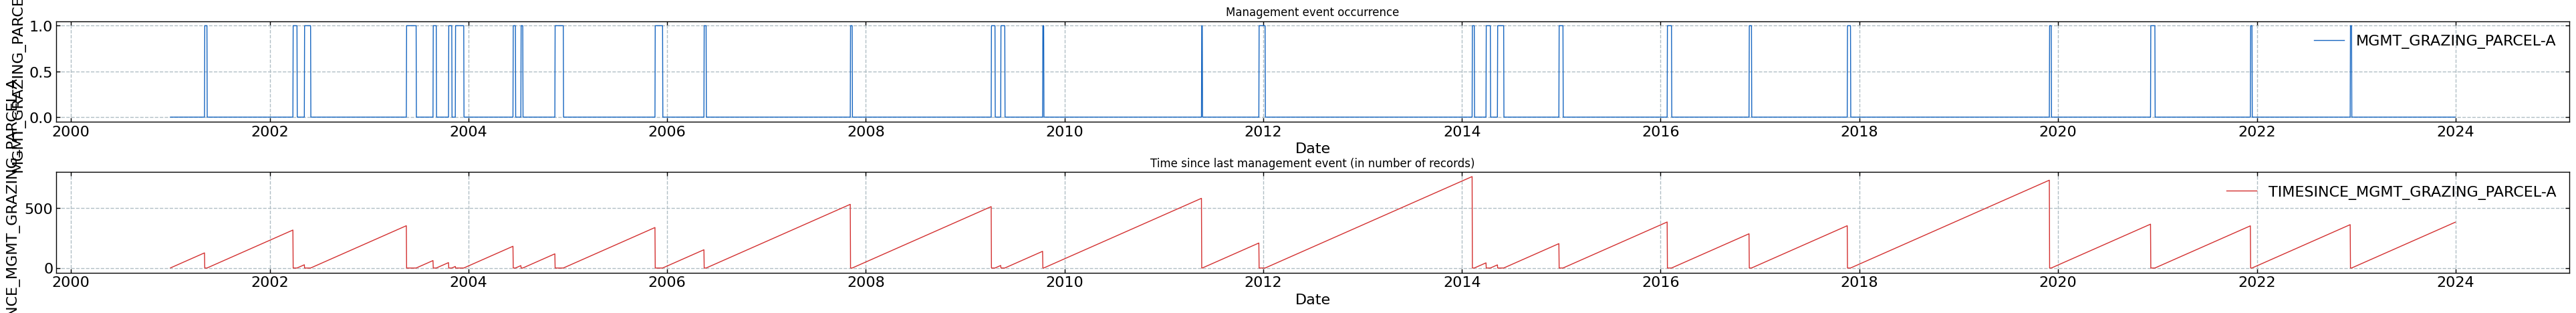

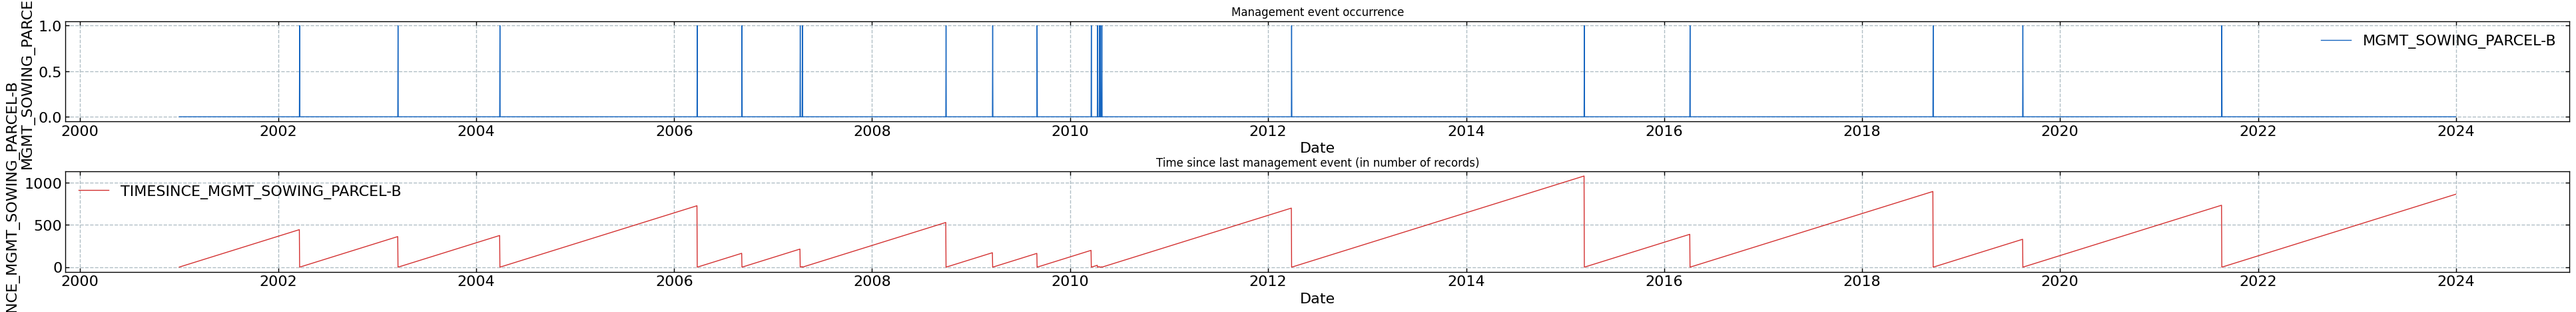

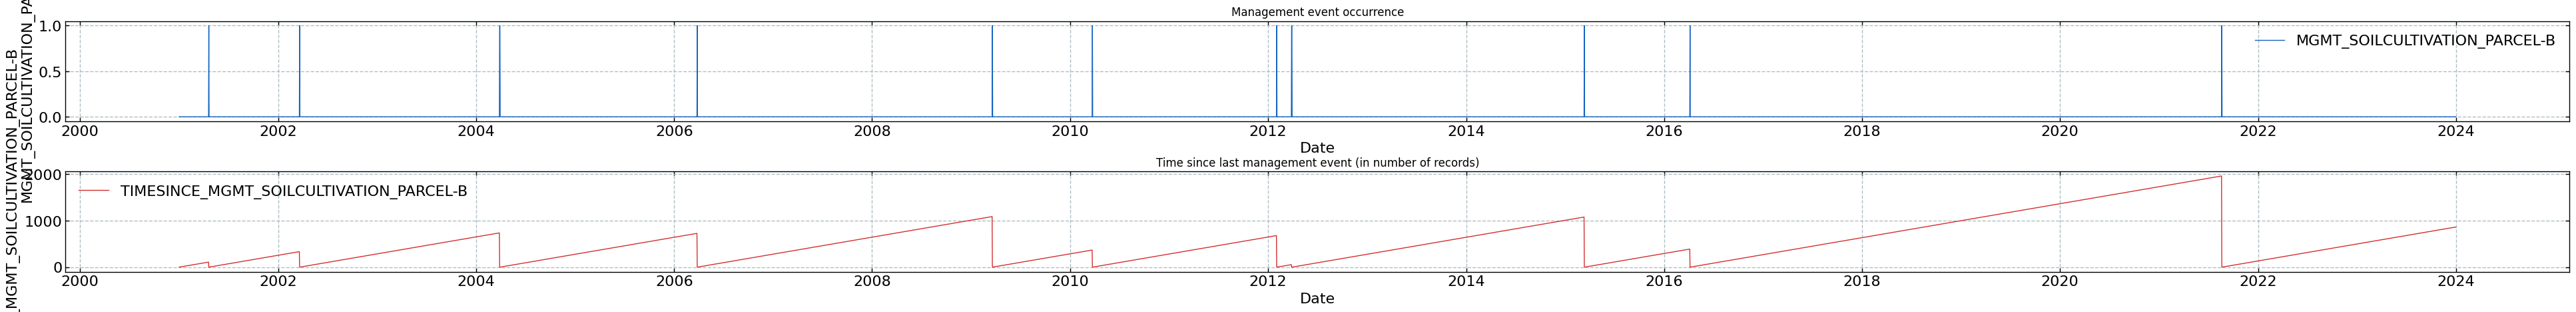

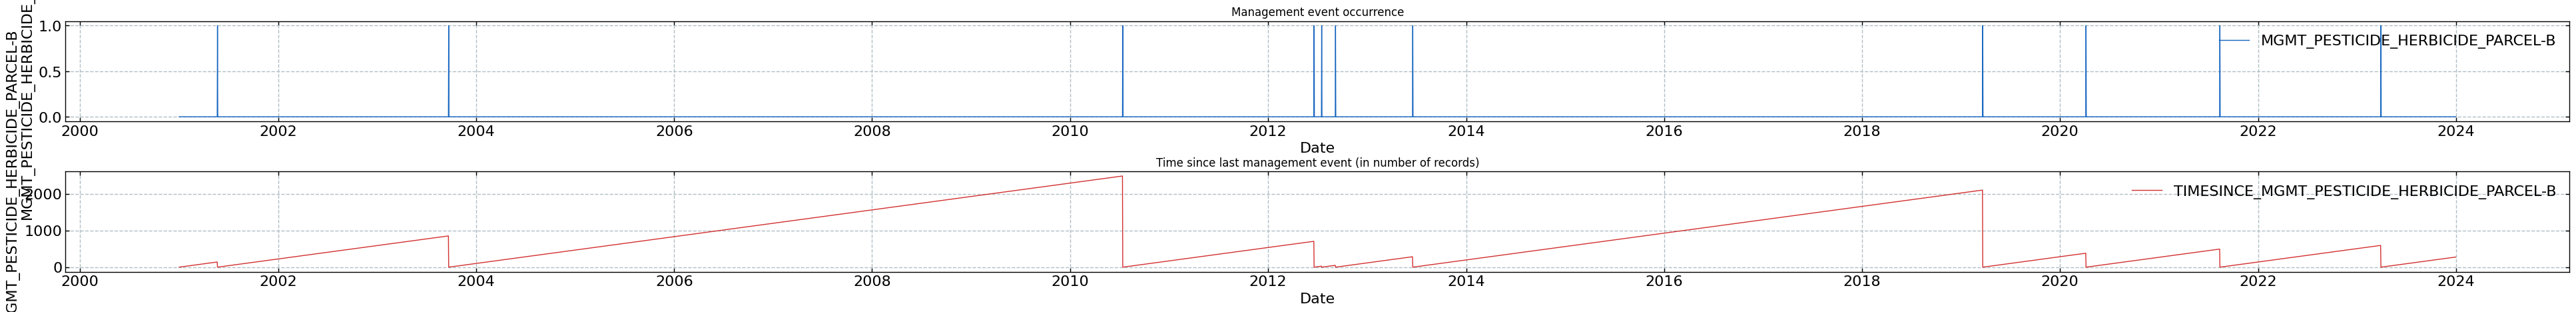

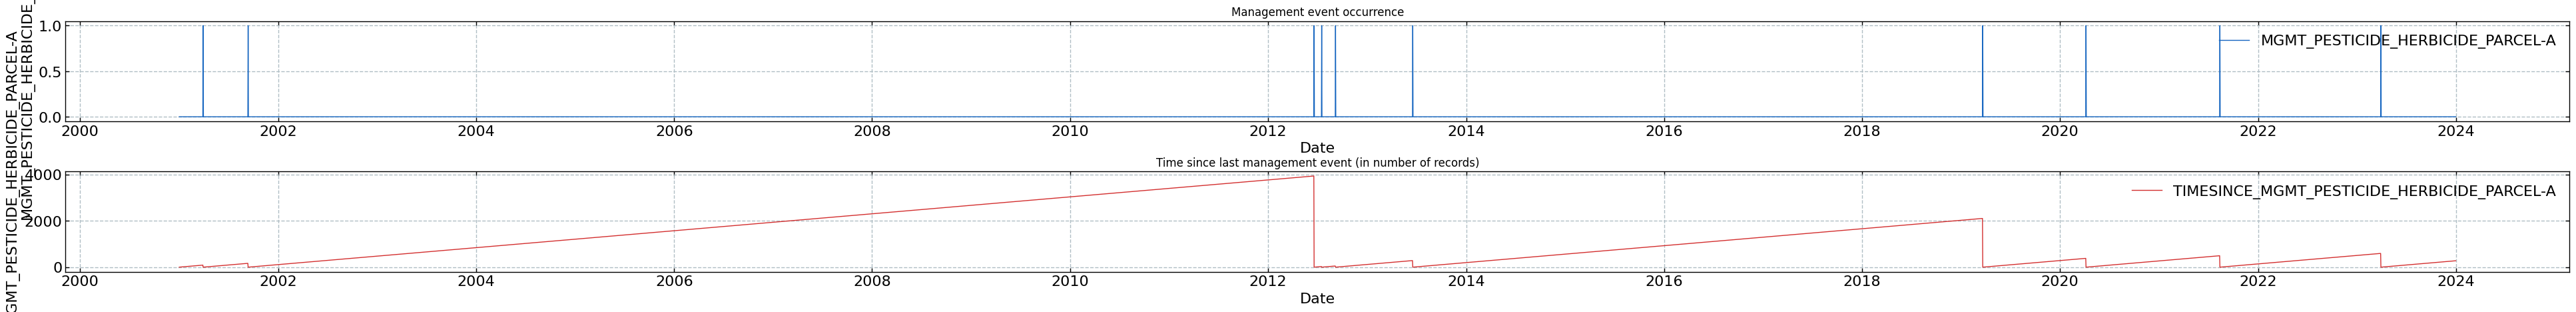

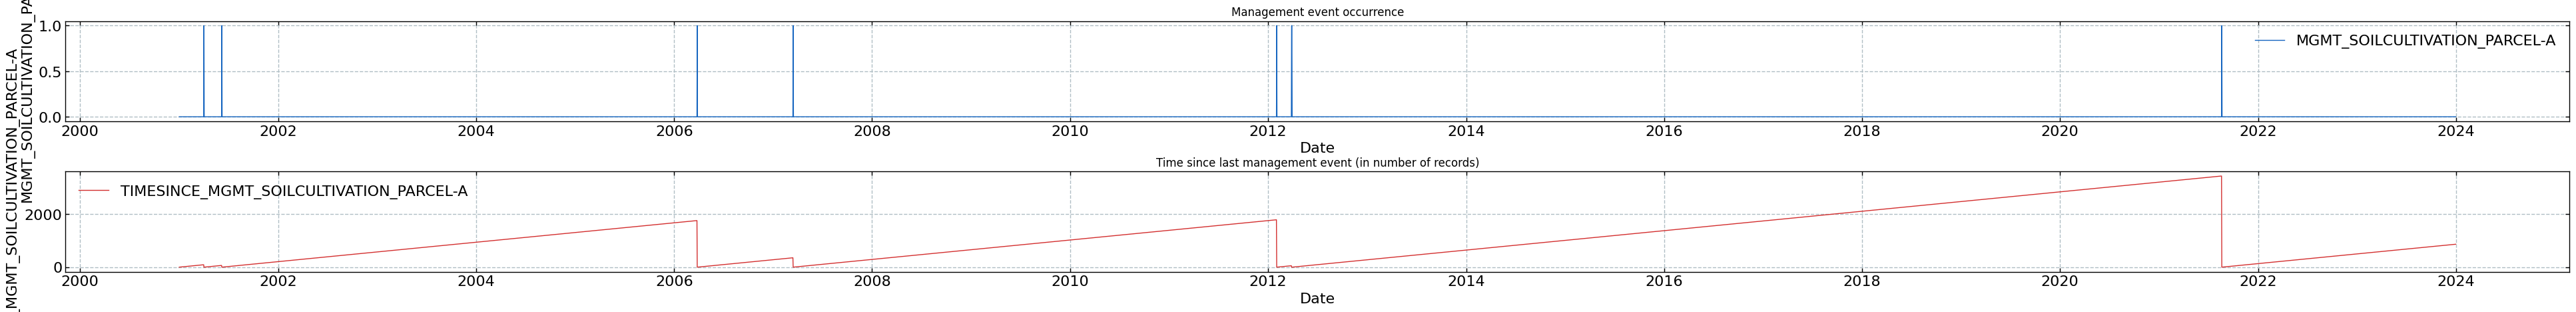

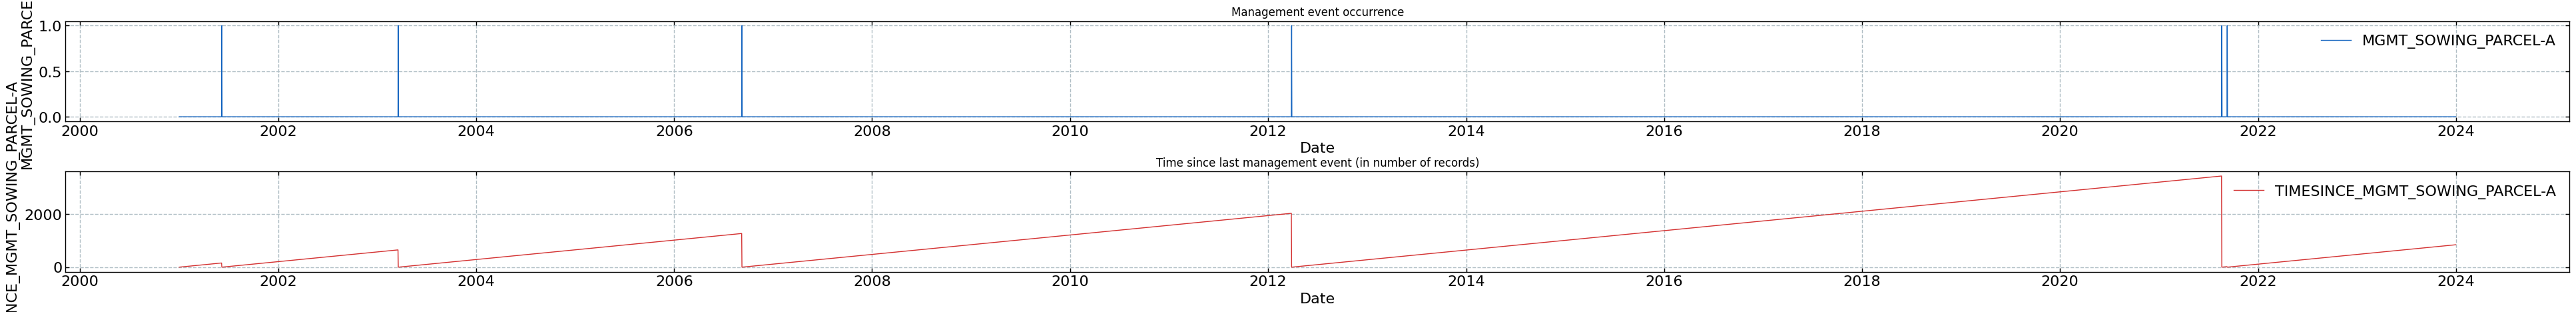

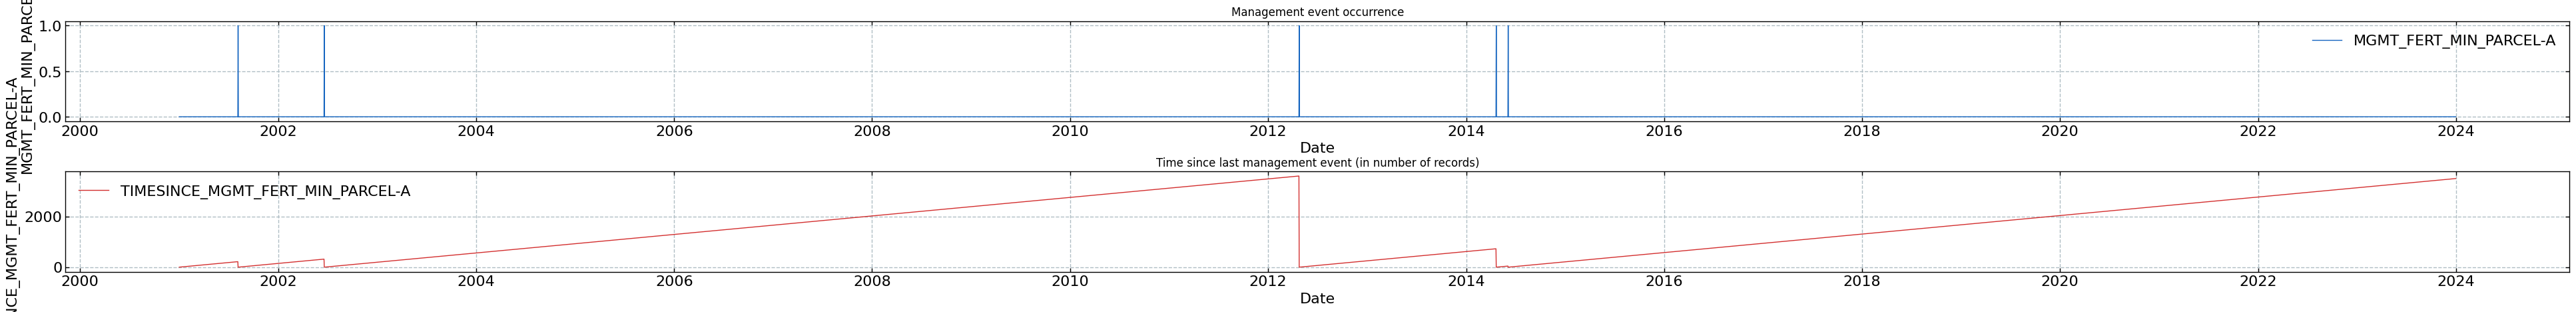

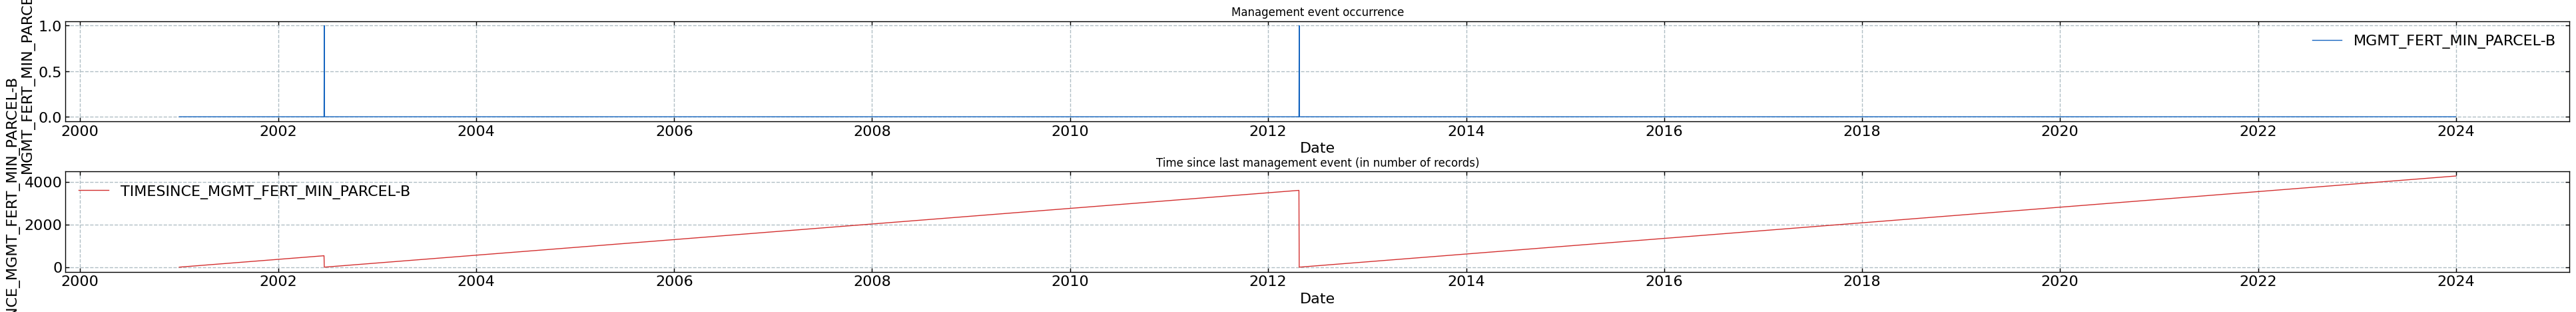

In [31]:
for v in mgmt_daily.columns:
    fig = plt.figure(facecolor='white', figsize=(40, 4), dpi=100, layout='constrained')
    gs = gridspec.GridSpec(2, 1)  # rows, cols
    gs.update(wspace=0.3, hspace=.5, left=0.03, right=0.97, top=0.97, bottom=0.03)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    TimeSeries(ax=ax1, series=mgmt_daily[v]).plot(color='#1565C0')
    TimeSeries(ax=ax2, series=timesincedf[f'TIMESINCE_{v}']).plot(color='#D32F2F')
    ax1.set_title("Management event occurrence", color='black')
    ax2.set_title("Time since last management event (in number of records)", color='black')    

## + Add `TIMESINCE` variables to management data

In [32]:
mgmt_daily = pd.concat([mgmt_daily, timesincedf], axis=1)
mgmt_daily

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,TIMESINCE_MGMT_FERT_ORG_PARCEL-A,TIMESINCE_MGMT_MOWING_PARCEL-A,TIMESINCE_MGMT_FERT_ORG_PARCEL-B,TIMESINCE_MGMT_GRAZING_PARCEL-B,TIMESINCE_MGMT_GRAZING_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-B,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-B
2001-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2001-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2001-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2001-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2001-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58,89,58,89,377,377,859,859,272,272,859,839,3492,4263
2023-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,90,59,90,378,378,860,860,273,273,860,840,3493,4264
2023-12-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,91,60,91,379,379,861,861,274,274,861,841,3494,4265
2023-12-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,92,61,92,380,380,862,862,275,275,862,842,3495,4266


In [33]:
collist = mgmt_daily.columns.tolist()
collist

['MGMT_MOWING_PARCEL-B',
 'MGMT_FERT_ORG_PARCEL-A',
 'MGMT_MOWING_PARCEL-A',
 'MGMT_FERT_ORG_PARCEL-B',
 'MGMT_GRAZING_PARCEL-B',
 'MGMT_GRAZING_PARCEL-A',
 'MGMT_SOWING_PARCEL-B',
 'MGMT_SOILCULTIVATION_PARCEL-B',
 'MGMT_PESTICIDE_HERBICIDE_PARCEL-B',
 'MGMT_PESTICIDE_HERBICIDE_PARCEL-A',
 'MGMT_SOILCULTIVATION_PARCEL-A',
 'MGMT_SOWING_PARCEL-A',
 'MGMT_FERT_MIN_PARCEL-A',
 'MGMT_FERT_MIN_PARCEL-B',
 'TIMESINCE_MGMT_MOWING_PARCEL-B',
 'TIMESINCE_MGMT_FERT_ORG_PARCEL-A',
 'TIMESINCE_MGMT_MOWING_PARCEL-A',
 'TIMESINCE_MGMT_FERT_ORG_PARCEL-B',
 'TIMESINCE_MGMT_GRAZING_PARCEL-B',
 'TIMESINCE_MGMT_GRAZING_PARCEL-A',
 'TIMESINCE_MGMT_SOWING_PARCEL-B',
 'TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B',
 'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B',
 'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A',
 'TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A',
 'TIMESINCE_MGMT_SOWING_PARCEL-A',
 'TIMESINCE_MGMT_FERT_MIN_PARCEL-A',
 'TIMESINCE_MGMT_FERT_MIN_PARCEL-B']

In [34]:
mgmt_daily.to_csv("21.4_mgmt_daily.csv")

</br>

</br>

---

# **HALF-HOURLY**

---

## Initiate footprint management columns

In [35]:
mgmt_cols = [sub.replace('_PARCEL-A', '') for sub in collist]
mgmt_cols = [sub.replace('_PARCEL-B', '') for sub in mgmt_cols]
mgmt_cols = [sub.replace('TIMESINCE_', '') for sub in mgmt_cols]
mgmt_cols = list(set(mgmt_cols))
display(mgmt_cols)

['MGMT_FERT_MIN',
 'MGMT_FERT_ORG',
 'MGMT_GRAZING',
 'MGMT_MOWING',
 'MGMT_SOILCULTIVATION',
 'MGMT_SOWING',
 'MGMT_PESTICIDE_HERBICIDE']

In [36]:
fp_mgmt_cols = [f"{c}_FOOTPRINT" for c in mgmt_cols]
fp_mgmt_cols

['MGMT_FERT_MIN_FOOTPRINT',
 'MGMT_FERT_ORG_FOOTPRINT',
 'MGMT_GRAZING_FOOTPRINT',
 'MGMT_MOWING_FOOTPRINT',
 'MGMT_SOILCULTIVATION_FOOTPRINT',
 'MGMT_SOWING_FOOTPRINT',
 'MGMT_PESTICIDE_HERBICIDE_FOOTPRINT']

In [37]:
# Add empty footprint columns to dataframe
mgmt_daily = mgmt_daily.reindex(columns = mgmt_daily.columns.tolist() + fp_mgmt_cols)
mgmt_daily

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,...,TIMESINCE_MGMT_SOWING_PARCEL-B,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-B,MGMT_FERT_MIN_FOOTPRINT,MGMT_FERT_ORG_FOOTPRINT,MGMT_GRAZING_FOOTPRINT,MGMT_MOWING_FOOTPRINT,MGMT_SOILCULTIVATION_FOOTPRINT,MGMT_SOWING_FOOTPRINT,MGMT_PESTICIDE_HERBICIDE_FOOTPRINT
2001-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,3,3,3,3,3,3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,...,4,4,4,4,4,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,...,5,5,5,5,5,5,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,58,...,859,859,272,272,859,839,3492,4263,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,...,860,860,273,273,860,840,3493,4264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,...,861,861,274,274,861,841,3494,4265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,...,862,862,275,275,862,842,3495,4266,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Half-hourly timestamp for management data

In [38]:
first_hh = pd.to_datetime(mgmt_daily.index[0]) + pd.Timedelta(minutes=15)
last_hh = pd.to_datetime(mgmt_daily.index[-1]) + pd.Timedelta(hours=23, minutes=45)
print(first_hh)
print(last_hh)

2001-01-01 00:15:00
2023-12-31 23:45:00


## Create half-hourly dataframe for management data

In [39]:
timestamp_hh = pd.date_range(first_hh, last_hh, freq='30min')
mgmt_hh = pd.DataFrame(index=timestamp_hh)
mgmt_hh['TIMESTAMP_MIDDLE'] = pd.to_datetime(mgmt_hh.index)  # For merging with daily time resolution management data
mgmt_hh['DATE'] = pd.to_datetime(mgmt_hh.index.date)  # For merging with daily time resolution management data
mgmt_hh

,TIMESTAMP_MIDDLE,DATE
2001-01-01 00:15:00,2001-01-01 00:15:00,2001-01-01
2001-01-01 00:45:00,2001-01-01 00:45:00,2001-01-01
2001-01-01 01:15:00,2001-01-01 01:15:00,2001-01-01
2001-01-01 01:45:00,2001-01-01 01:45:00,2001-01-01
2001-01-01 02:15:00,2001-01-01 02:15:00,2001-01-01
...,...,...
2023-12-31 21:45:00,2023-12-31 21:45:00,2023-12-31
2023-12-31 22:15:00,2023-12-31 22:15:00,2023-12-31
2023-12-31 22:45:00,2023-12-31 22:45:00,2023-12-31
2023-12-31 23:15:00,2023-12-31 23:15:00,2023-12-31


In [40]:
mgmt_daily['DATE'] = mgmt_daily.index
mgmt_daily['DATE'] = pd.to_datetime(mgmt_daily['DATE'])
mgmt_daily.head(3)

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,...,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-B,MGMT_FERT_MIN_FOOTPRINT,MGMT_FERT_ORG_FOOTPRINT,MGMT_GRAZING_FOOTPRINT,MGMT_MOWING_FOOTPRINT,MGMT_SOILCULTIVATION_FOOTPRINT,MGMT_SOWING_FOOTPRINT,MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,DATE
2001-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-01-01
2001-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-01-02
2001-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,3,3,3,3,3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-01-03


In [41]:
# Merge on DATE column
mgmt_hh = pd.merge(mgmt_hh, mgmt_daily, on='DATE')
mgmt_hh = mgmt_hh.set_index('TIMESTAMP_MIDDLE')
mgmt_hh = mgmt_hh.drop('DATE', axis=1)
mgmt_hh

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,...,TIMESINCE_MGMT_SOWING_PARCEL-B,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-B,MGMT_FERT_MIN_FOOTPRINT,MGMT_FERT_ORG_FOOTPRINT,MGMT_GRAZING_FOOTPRINT,MGMT_MOWING_FOOTPRINT,MGMT_SOILCULTIVATION_FOOTPRINT,MGMT_SOWING_FOOTPRINT,MGMT_PESTICIDE_HERBICIDE_FOOTPRINT
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 02:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,...,863,863,276,276,863,843,3496,4267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 22:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,...,863,863,276,276,863,843,3496,4267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 22:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,...,863,863,276,276,863,843,3496,4267,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## + Add wind direction to management data

In [42]:
mgmt_hh['WD'] = winddir.copy()
mgmt_hh['WD']

TIMESTAMP_MIDDLE
2001-01-01 00:15:00        NaN
2001-01-01 00:45:00        NaN
2001-01-01 01:15:00        NaN
2001-01-01 01:45:00        NaN
2001-01-01 02:15:00        NaN
                        ...   
2023-12-31 21:45:00    116.724
2023-12-31 22:15:00    116.197
2023-12-31 22:45:00    142.519
2023-12-31 23:15:00    140.207
2023-12-31 23:45:00    135.988
Name: WD, Length: 403200, dtype: float64

## List of managments in half-hourly dataframe

In [43]:
mgmt_hh_cols = mgmt_hh.columns.to_list()
mgmt_hh_cols = [sub.replace('_PARCEL-A', '') for sub in mgmt_hh_cols]
mgmt_hh_cols = [sub.replace('_PARCEL-B', '') for sub in mgmt_hh_cols]
mgmt_hh_cols = [sub.replace('TIMESINCE_', '') for sub in mgmt_hh_cols]
mgmt_hh_cols = [sub.replace('_FOOTPRINT', '') for sub in mgmt_hh_cols]
mgmt_hh_cols.remove("WD")
mgmt_hh_cols = list(set(mgmt_hh_cols))
mgmt_hh_cols

['MGMT_FERT_MIN',
 'MGMT_FERT_ORG',
 'MGMT_GRAZING',
 'MGMT_MOWING',
 'MGMT_SOILCULTIVATION',
 'MGMT_SOWING',
 'MGMT_PESTICIDE_HERBICIDE']

## Fill footprint management columns depending on wind direction

- Parcel division runs from 250° to 70°
- Parcel A: >= 250, < 70
- Parcel B: >= 70, < 250

In [44]:
locs_parcel_a = (mgmt_hh['WD'] >= 250) | (mgmt_hh['WD'] < 70)
locs_parcel_b = (mgmt_hh['WD'] >= 70) & (mgmt_hh['WD'] < 250)

for m in mgmt_hh_cols:    
    fp_var = f"{m}_FOOTPRINT"
    fp_timesince_var = f"TIMESINCE_{m}_FOOTPRINT"
    
    parcela_var = f"{m}_PARCEL-A"
    if parcela_var in mgmt_hh.columns:        
        parcela_timesince_var = f"TIMESINCE_{m}_PARCEL-A"
        mgmt_hh.loc[locs_parcel_a, fp_var] = mgmt_hh.loc[locs_parcel_a, parcela_var]
        mgmt_hh.loc[locs_parcel_a, fp_timesince_var] = mgmt_hh.loc[locs_parcel_a, parcela_timesince_var]
    
    parcelb_var = f"{m}_PARCEL-B"
    if parcelb_var in mgmt_hh.columns:
        parcelb_timesince_var = f"TIMESINCE_{m}_PARCEL-B"
        mgmt_hh.loc[locs_parcel_b, fp_var] = mgmt_hh.loc[locs_parcel_b, parcelb_var]
        mgmt_hh.loc[locs_parcel_b, fp_timesince_var] = mgmt_hh.loc[locs_parcel_b, parcelb_timesince_var]

In [45]:
mgmt_hh

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,...,MGMT_FERT_MIN_FOOTPRINT,MGMT_FERT_ORG_FOOTPRINT,MGMT_GRAZING_FOOTPRINT,MGMT_MOWING_FOOTPRINT,MGMT_SOILCULTIVATION_FOOTPRINT,MGMT_SOWING_FOOTPRINT,MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,WD,TIMESINCE_MGMT_FERT_MIN_FOOTPRINT,TIMESINCE_MGMT_FERT_ORG_FOOTPRINT,TIMESINCE_MGMT_GRAZING_FOOTPRINT,TIMESINCE_MGMT_MOWING_FOOTPRINT,TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT,TIMESINCE_MGMT_SOWING_FOOTPRINT,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 02:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.724,4267.0,93.0,381.0,62.0,863.0,863.0,276.0
2023-12-31 22:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.197,4267.0,93.0,381.0,62.0,863.0,863.0,276.0
2023-12-31 22:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.519,4267.0,93.0,381.0,62.0,863.0,863.0,276.0


### Plot (example one day)

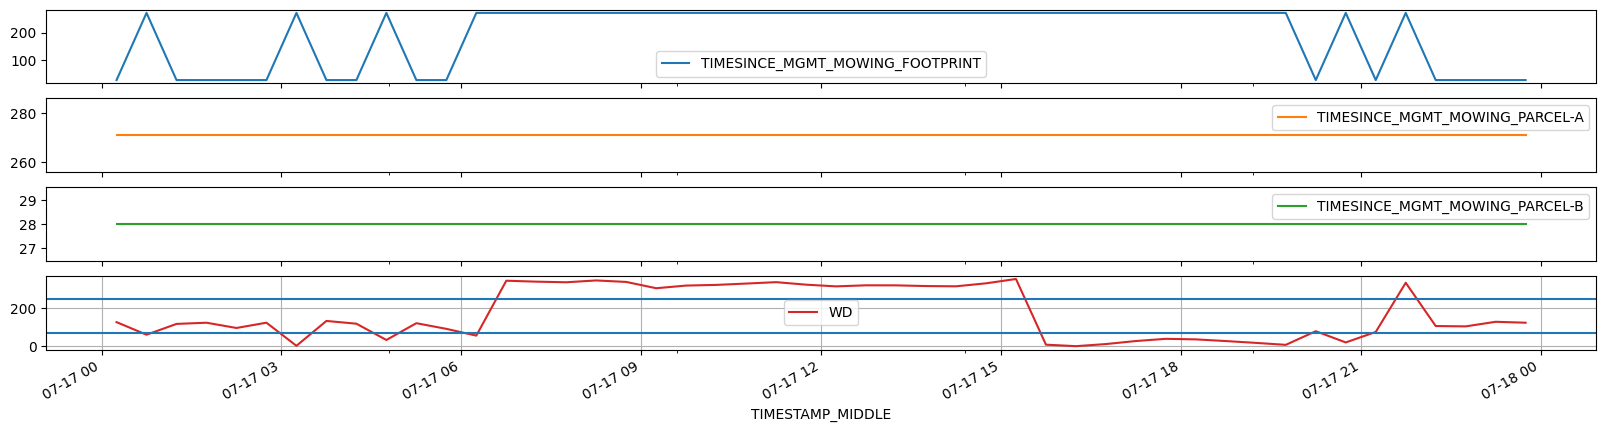

In [46]:
locs = (mgmt_hh.index.year == 2014) & (mgmt_hh.index.month == 7) & (mgmt_hh.index.day == 17)
mgmt_hh.loc[locs, ['TIMESINCE_MGMT_MOWING_FOOTPRINT', 'TIMESINCE_MGMT_MOWING_PARCEL-A', 'TIMESINCE_MGMT_MOWING_PARCEL-B', 'WD']].plot(x_compat=True, subplots=True, figsize=(20, 5))
plt.axhline(250)
plt.axhline(70)
plt.grid();

</br>

</br>

---

# Export data to file

---

## Keep management info from 2005 onwards

In [47]:
keeplocs = (mgmt_hh.index.year >= 2005) & (mgmt_hh.index.year <= 2023)
mgmt_hh = mgmt_hh.loc[keeplocs].copy()
mgmt_hh

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,...,MGMT_FERT_MIN_FOOTPRINT,MGMT_FERT_ORG_FOOTPRINT,MGMT_GRAZING_FOOTPRINT,MGMT_MOWING_FOOTPRINT,MGMT_SOILCULTIVATION_FOOTPRINT,MGMT_SOWING_FOOTPRINT,MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,WD,TIMESINCE_MGMT_FERT_MIN_FOOTPRINT,TIMESINCE_MGMT_FERT_ORG_FOOTPRINT,TIMESINCE_MGMT_GRAZING_FOOTPRINT,TIMESINCE_MGMT_MOWING_FOOTPRINT,TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT,TIMESINCE_MGMT_SOWING_FOOTPRINT,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 01:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-01 02:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.724,4267.0,93.0,381.0,62.0,863.0,863.0,276.0
2023-12-31 22:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.197,4267.0,93.0,381.0,62.0,863.0,863.0,276.0
2023-12-31 22:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.519,4267.0,93.0,381.0,62.0,863.0,863.0,276.0


## Plot

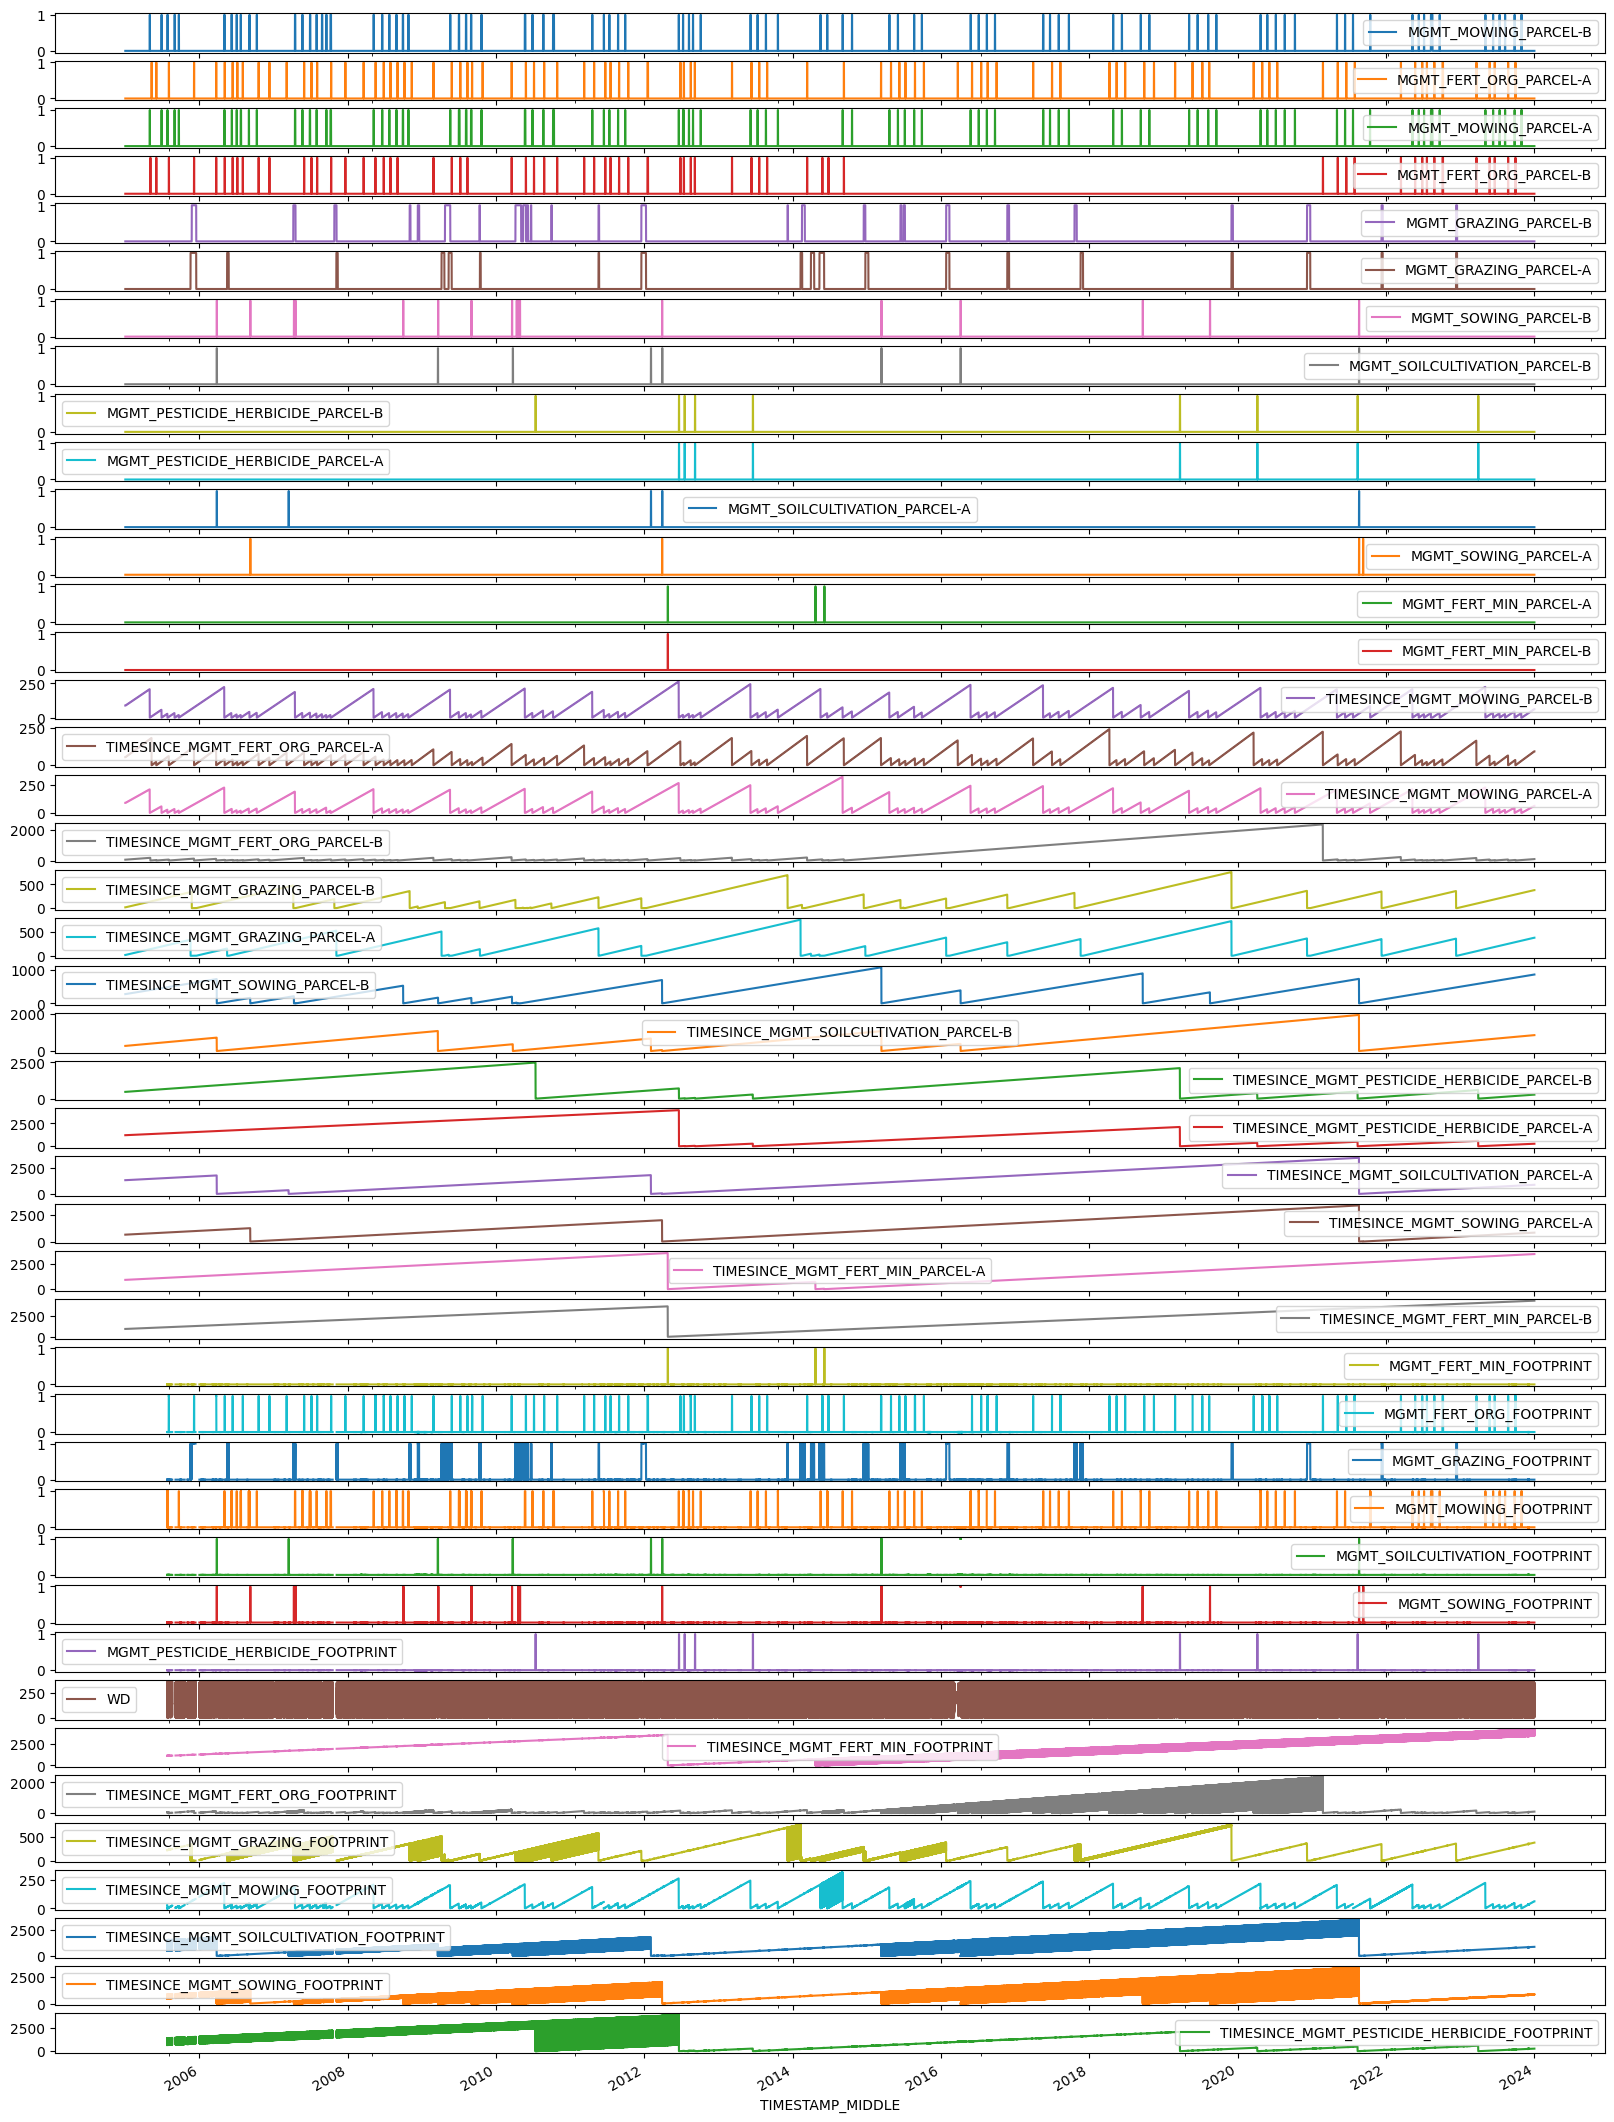

In [48]:
mgmt_hh.plot(x_compat=True, subplots=True, figsize=(20, 30));

## Save to file

In [49]:
mgmt_hh.to_csv("21.5_mgmt_full_timestamp.csv")